In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input, concatenate
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# loading the dataset

In [2]:
df = pd.read_excel("Crude Oil Prices Daily.xlsx", usecols=[1])
df

,Closing Value
0,25.56
1,26.00
2,26.53
3,25.85
4,25.87
...,...
8218,74.19
8219,NaN
8220,73.05
8221,73.78


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8223 entries, 0 to 8222
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Closing Value  8216 non-null   float64
dtypes: float64(1)
memory usage: 64.4 KB


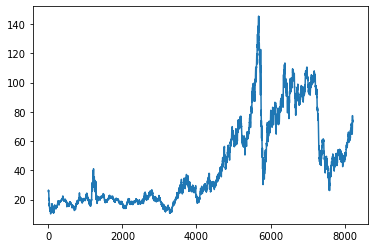

In [4]:
plt.plot(df)
plt.show()

# pre processing

In [5]:
df.isna().sum()

Closing Value    7
dtype: int64

In [6]:
df["Closing Value"].fillna(df["Closing Value"].mean(), inplace=True) 
df.isna().sum()

Closing Value    0
dtype: int64

In [7]:
x = df.values
x

array([[25.56],
       [26.  ],
       [26.53],
       ...,
       [73.05],
       [73.78],
       [73.93]])

In [8]:
# normalising 
scaler = MinMaxScaler(feature_range=(0,1))
x = scaler.fit_transform(x)

In [9]:
# splitting into train and test
train_size = int(len(x) * 0.7)
test_size = len(x) - train_size
train, test = x[:train_size,:], x[train_size:,:]
print(len(train), len(test))

5756 2467


In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

"""
input [1 2 3 4 5 6]
if n_steps = 3
output :
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
"""

'\ninput [1 2 3 4 5 6]\nif n_steps = 3\noutput :\n[1 2 3] 4\n[2 3 4] 5\n[3 4 5] 6\n'

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [12]:
window_size = 10
trainX, trainY = create_dataset(train, window_size)
testX, testY = create_dataset(test, window_size)

In [13]:
# reshaping to lstm input size
trainX = np.reshape(trainX, (-1,1,trainX.shape[1]))
testX = np.reshape(testX, (-1,1,testX.shape[1]))

lstm input format is [batchsize, timestamp, features]